# Predicting Heart Disease Using Classification 


## Introduction 

ardiovascular diseases (CVDs) are the leading cause of death globally, taking an estimated 17.9 million lives each year. One of the best ways to reduce the mortality and severity of heart diseases is early detection in an individual.
Our dataset is created by hospitals and institutions from three different countries (Hungarian, Cleveland, and VA) and is taken from the UCI Machine Learning Repository. The original database involves the variables such as age, sex, chest pain (cp), cholesterol (chol), resting blood pressure (trestbps), maximum heart rate achieved (thalach) etc. and a final column which classifies the presence of heart disease (angiographic disease status) where 0 represents the absence of heart disease and 1-4 represents the presence of heart disease.
In this project, we seek to utilize some commonly available medical metrics -- age, maximum heart rate achieved, and cholesterol-- to predict whether an individual has heart disease or not.


## Preliminary exploratory data analysis:

Before beginning the project, we load all the required libraries and also restrict the size of our tables to make sure no particular table takes too much space. 

In [71]:
# loading all the required libraries. 
library(tidyverse) 
library(dplyr)
library(tidymodels) 
library(gridExtra)
library(repr)
options(repr.matrix.max.rows = 6)
set.seed(1)

We first examined the four possible data set for our analysis. We chose four different locations to have a better representation of the population and as different locations contribute to different results we can have a better estimate. Moreover, more data is usually helps to have a better training model.
we want to have almost equal amount of data from each location in our training and testing set and avoid any unluckiness, such as training out model based on data that are mostly from two locations and testing it on the testing set that mainly includes the third one. Therefore, we added the location column, to use it later when spiliting our data into training and testing set.
We decided to ignore one of the sub-datasets (heart-data-2, data from switzerland) as the dataset contained numerous missing values for important columns such as cholesterol. 
The next step was renaming the columns and binding the three data sets together. 

In [72]:
#Purpose of the cell: loading the required datasets, mutating and merging them
heart_data1 <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.hungarian.data", col_names=FALSE)
heart_data2 <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data", col_names=FALSE)
heart_data3 <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names=FALSE)
heart_data4 <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.va.data", col_names=FALSE)

# After exploring the heart_data-2, we noticed that it is missing value for many key predictors namely, cholestrol.
#Therefore, we decided to not use that one and bind the rest together

# we want to have almost equal amount of data from each location in our training and testing set and avoid any unluckiness,
# such as training out model based on data that are mostly from two locations and testing it on the testing set that
# mainly includes the third one. Therefore, we added the location, to use it later when spiliting our data into training and testing set.

hungarian_data <- heart_data1 %>%
    mutate (location = "Hungarian")
cleveland_data <- heart_data3 %>%
    mutate (location = "Cleveland")
va_data <- heart_data4 %>%
    mutate (location = "Va")

#merging the data from the various cities 
heart_data <- rbind (hungarian_data, cleveland_data, va_data)
#adding column names to the data 
colnames(heart_data) <- c("age", "sex", "cp", "trestbps", "chol", "fbs",  "restecg", "thalach", "exang",  "oldpeak", "slope",  "ca",  "thal", "num", "location")
#viewing the data
head(heart_data)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_character(),
  X9 = col_character(),
  X10 = col_double(),
  X11 = col_character(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_double(),
  X6 = col_character(),
  X7 = col_character(),
  X8 = col_character(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character(),
  X13 = col_character(),
  X14 = col_double()
)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_double(),
  X5 = col_double(),
  X6 = col_double(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_double(),
  X10 = col_double(),
  X11 = col_d

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,location
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>
28,1,2,130,132,0,2,185,0,0,?,?,?,0,Hungarian
29,1,2,120,243,0,0,160,0,0,?,?,?,0,Hungarian
29,1,2,140,?,0,0,170,0,0,?,?,?,0,Hungarian
30,0,1,170,237,0,1,170,0,0,?,?,6,0,Hungarian
31,0,2,100,219,0,1,150,0,0,?,?,?,0,Hungarian
32,0,2,105,198,0,0,165,0,0,?,?,?,0,Hungarian


We continue with tidying the data by altering the “num” from the original dataset by changing the values [0, 4] to either yes or no. In the original dataset, 0 indicates absence of heart-disease and [1,4] all represent presence of the same, just with different magnitude. As we were only concerned with the presence(or absence) of heart disease, we changed the numbers to “yes” or “no”. 


We chose those three based on:
Age - People age 65 and older are much more likely than younger people to suffer a heart attack, to have a stroke, or to develop heart disease and heart failure. . This can be due to the heart not being able to beat fast enough during physical activity or times of stress as it did earlier or due to the buildup of fatty deposits in the walls of arteries over the years. It is also evident from our plot that ss age increases, more proportion of people have heart disease; after the dashed line, representing the mean value, the ratio of people with heart disease is higher.
Cholesterol: Increased amounts of cholesterol can build up in the wall of your arteries leading to the thinning of the arteries and ultimately leading to less blood flow to the heart muscle. This can lead to various heart diseases and even heart attacks, in some cases Similarly, we can see in our scatter and histogram plots that people with cholesterol of over 200 mg/dl are more likely to have heart disease.
Maximum Heart Rate Achieved: A higher heart rate is a good thing that leads to greater fitness A higher heart rate means that the heart is functioning well and is able to pump blood quickly and effectively. Lower maximum heart rate means that either the heart is unable to pump blood at higher speeds or that the person isn't doing activities that allow their heart rate to reach such levels, in most cases. Our plots also show that people who did not get to a certain maximum heart rate, around 140, had a significantly higher chance of heart failure. 

Based on the variables decided, we selected the columns that were going to be used in the data analysis. Additionally, we also changed the type of certain columns to numeric to aid in our analysis. 

In [73]:
#tidying the data further by modifying num column to show weather the patient has heart disease or not
num <- heart_data %>%
    select (num) %>%
    mutate (num = as.character (num))
num [num == "1"] <- "Y"
num [num == "2"] <- "Y"
num [num == "3"] <- "Y"
num [num == "4"] <- "Y"
num [num == "0"] <- "N"
num <- num %>%
 mutate (num = as_factor (num))
#selecting the required columns 
# we are selecting the three predictors that we are using for this analysis. 
#The rest of the columns either were not numerical values or did not have a clear correlation with heart disease.

heart_data_selected <- heart_data%>%
    select (age, chol, thalach, location)
#merging the data again 
heart_data_merged <- cbind(heart_data_selected, num) %>%
    rename ("heart_disease" = "num")
#changing the data types of some columns 
heart_data_final <- heart_data_merged %>%
     mutate (chol = as.numeric (chol),
            thalach = as.numeric (thalach))           
head(heart_data_final)

heart_data_final

Warning message:
“Problem with `mutate()` input `chol`.
ℹ NAs introduced by coercion
ℹ Input `chol` is `as.numeric(chol)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”
Warning message:
“Problem with `mutate()` input `thalach`.
ℹ NAs introduced by coercion
ℹ Input `thalach` is `as.numeric(thalach)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


,age,chol,thalach,location,heart_disease
,<dbl>,<dbl>,<dbl>,<chr>,<fct>
1,28,132,185,Hungarian,N
2,29,243,160,Hungarian,N
3,29,NA,170,Hungarian,N
4,30,237,170,Hungarian,N
5,31,219,150,Hungarian,N
6,32,198,165,Hungarian,N


age,chol,thalach,location,heart_disease
<dbl>,<dbl>,<dbl>,<chr>,<fct>
28,132,185,Hungarian,N
29,243,160,Hungarian,N
29,NA,170,Hungarian,N
⋮,⋮,⋮,⋮,⋮
55,223,100,Va,Y
58,385,NA,Va,N
62,254,93,Va,Y


As talked about earlier, to make sure the data is represented(based on their location) proportionally in both the training and testing data. We split the data into different data sets based on the location column that we added earlier. Then, the location specific data was split into testing and training data. Now, we have location specific training and testing data which can be merged together to make up our final testing and training data. 
Before proceeding with the splitting, we set the seed to ensure the reproducibility of the data as the process of splitting the data into training and testing involves randomness. 

In [74]:
# seperating the data into different data set based on their location
set.seed(1)

   
hungarian_data_cleaned <- heart_data_final %>%
    filter (location == "Hungarian") %>%
    na.omit () %>%
    filter (chol != 0)

cleveland_data_cleaned <- heart_data_final %>%
    filter (location == "Cleveland") %>%
    na.omit () %>%
    filter (chol != 0)

va_data_cleaned <- heart_data_final %>%
    filter (location == "Va") %>%
    na.omit () %>%
    filter (chol != 0)

# spliting the data into training and testing for each of those locations

heart_data_split_hung <- initial_split(hungarian_data_cleaned, prop=.75, strata = heart_disease)
heart_data_training_hung <- training(heart_data_split_hung) 
heart_data_testing_hung <- testing(heart_data_split_hung)

heart_data_split_clev <- initial_split(cleveland_data_cleaned, prop=.75, strata = heart_disease)
heart_data_training_clev <- training(heart_data_split_clev) 
heart_data_testing_clev <- testing(heart_data_split_clev)

heart_data_split_va <- initial_split(va_data_cleaned, prop=.75, strata = heart_disease)
heart_data_training_va <- training(heart_data_split_va) 
heart_data_testing_va <- testing(heart_data_split_va)

#putting all of the training-set together
heart_data_training <- rbind (heart_data_training_hung, heart_data_training_clev, heart_data_training_va)


#putting all of the testing-set together
heart_data_testing <- rbind (heart_data_testing_hung, heart_data_testing_clev, heart_data_testing_va)



Now, we move on to summarising the data. Firstly, we calculated the mean of the three predictors: age, chol, thalach (maximum heart rate). After calculating the mean, we presented it in the form of a table that has been tidied using the pivot longer function to aid in readability of the reader. Second, we calculated the number of NAs in each of the columns to get an idea of the missing values in our dataset. Lastly, we ascertained the proportion of people with heart disease in our final dataset and proportion of people without heart disease. 


In [75]:
#Goal of the cell: summarizing the data 

heart_data_cleaned_final <- heart_data_final %>%
    select (- location)

#calculating the mean 
predictors_mean <- heart_data_training %>%
    summarize(across (age:thalach, mean, na.rm = TRUE))

#using pivot_longer to show the mean value of each column in a table
predictors_mean_final <- pivot_longer(predictors_mean, 
                               cols = age:thalach, 
                               names_to = "predictors",
                              values_to = "mean")
predictors_mean_final

#counting the missing data 
na_count <- map_df(heart_data_cleaned_final, ~sum(is.na(.)))
#using pivot_longer to show the number of NAs in a table
na_count_final <- pivot_longer(na_count,
                               cols = age:heart_disease,
                               names_to = "predictors",
                              values_to = "number_of_nas")
na_count_final

#Proportion of heart disease 
heart_disease_proportion <- heart_data_training %>%
    group_by (heart_disease) %>%
    summarize (observation_number = n()) %>%
    mutate (percent = 100*observation_number/nrow(heart_data_training))
heart_disease_proportion  

predictors,mean
<chr>,<dbl>
age,52.27308
chol,244.27898
thalach,141.14342


predictors,number_of_nas
<chr>,<int>
age,0
chol,30
thalach,54
heart_disease,0


`summarise()` ungrouping output (override with `.groups` argument)



heart_disease,observation_number,percent
<fct>,<int>,<dbl>
N,268,52.65226
Y,241,47.34774


Now, we visualise the data to get an insight into the data and use it to aid in choosing the predictors. Firstly, we visualise the data using scatterplots where we plotted 2 of the 3 predictors on the axes. Also, the points were coloured based on whether they represent “yes” or “no” in the heart disease column. This allowed us to gain some insight which was used to select the predictor variables. After the scatterplot, we used histograms to display the distribution of the predictors over various values of that particular predictor. Again, we colour coded the histogram to represent the ‘yes’ or ‘no’ under the heart disease column. This again allowed us to gain insight similar to that from the scatterplot which was used to select predictors. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



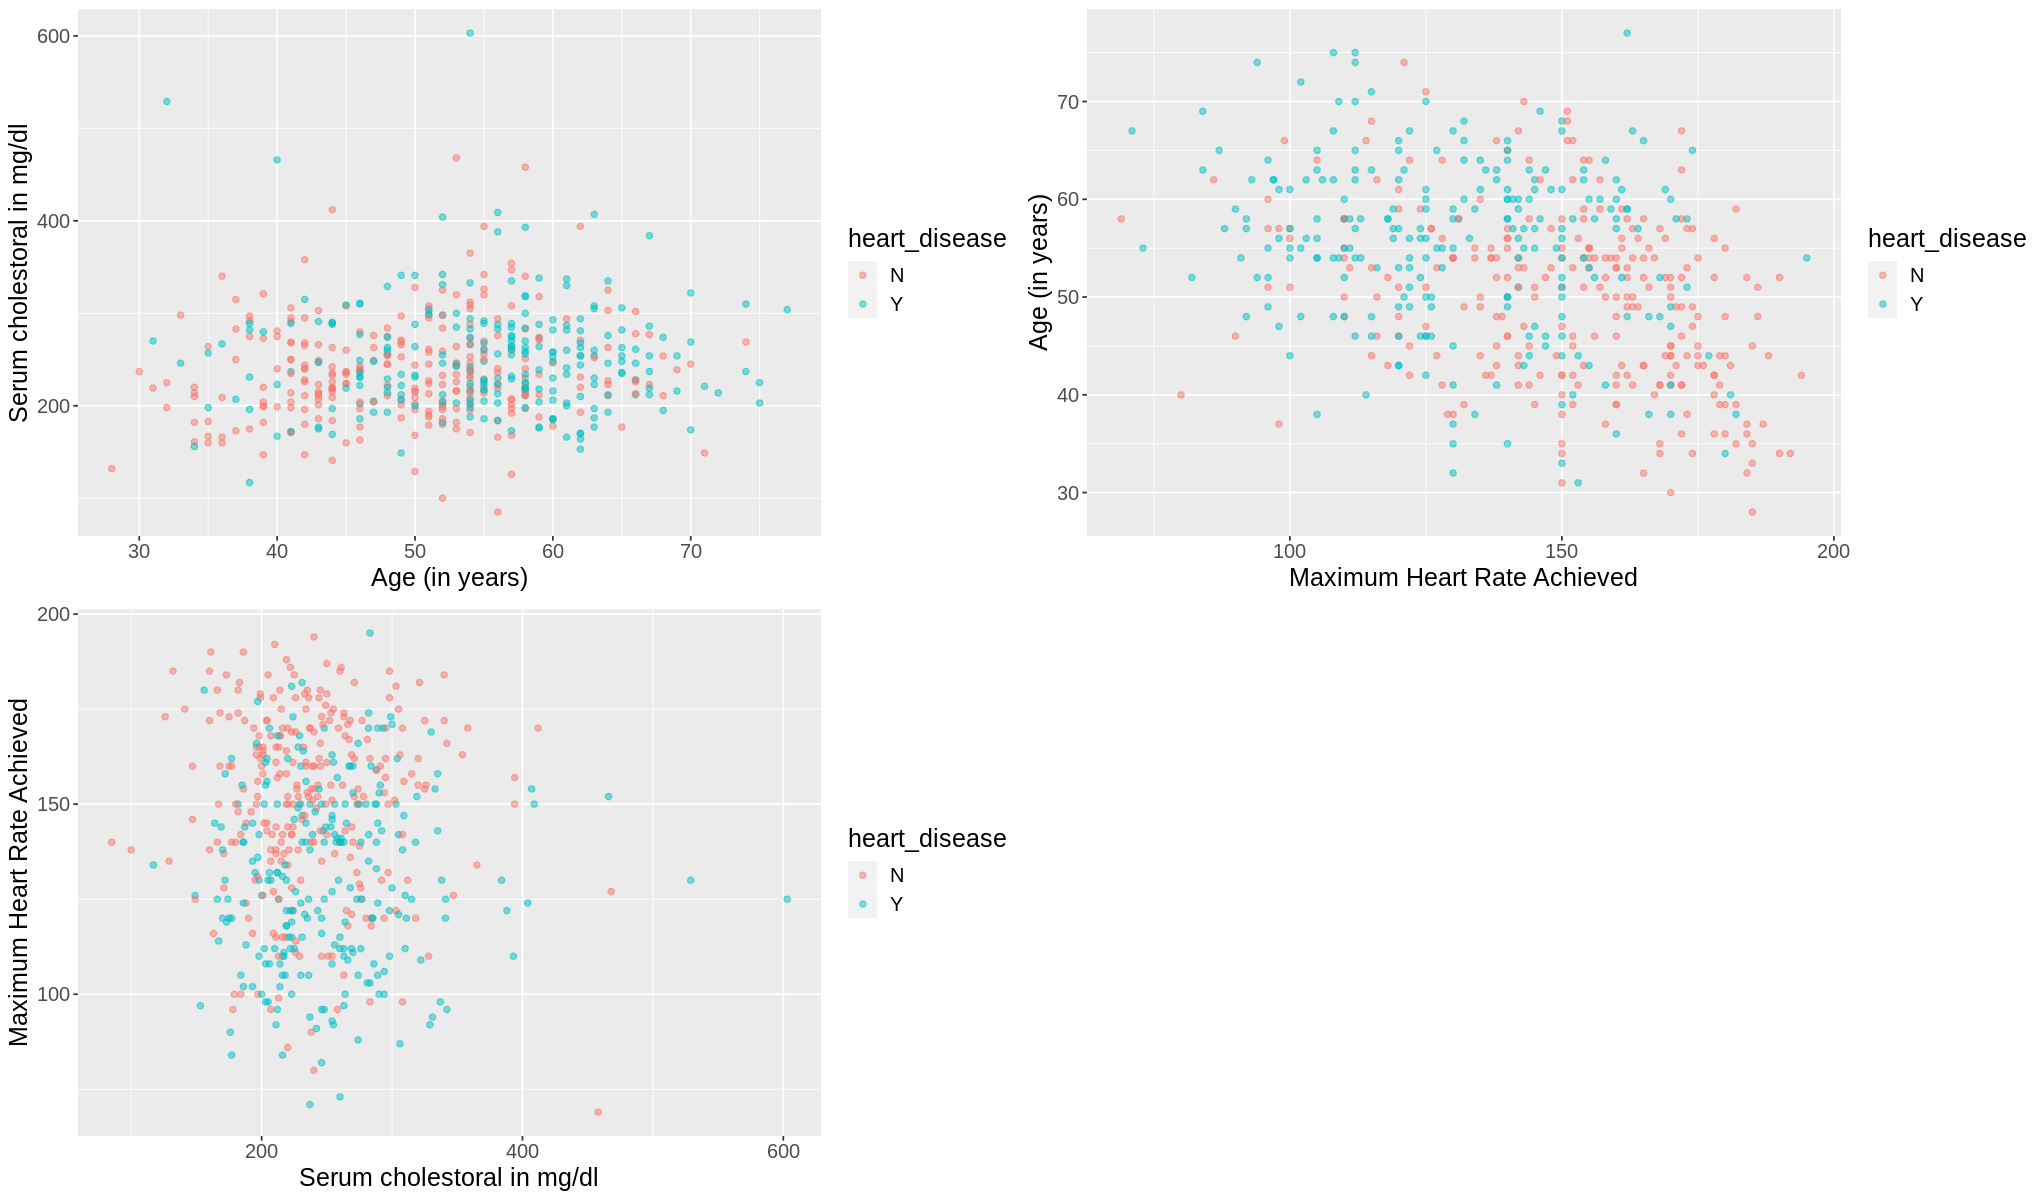

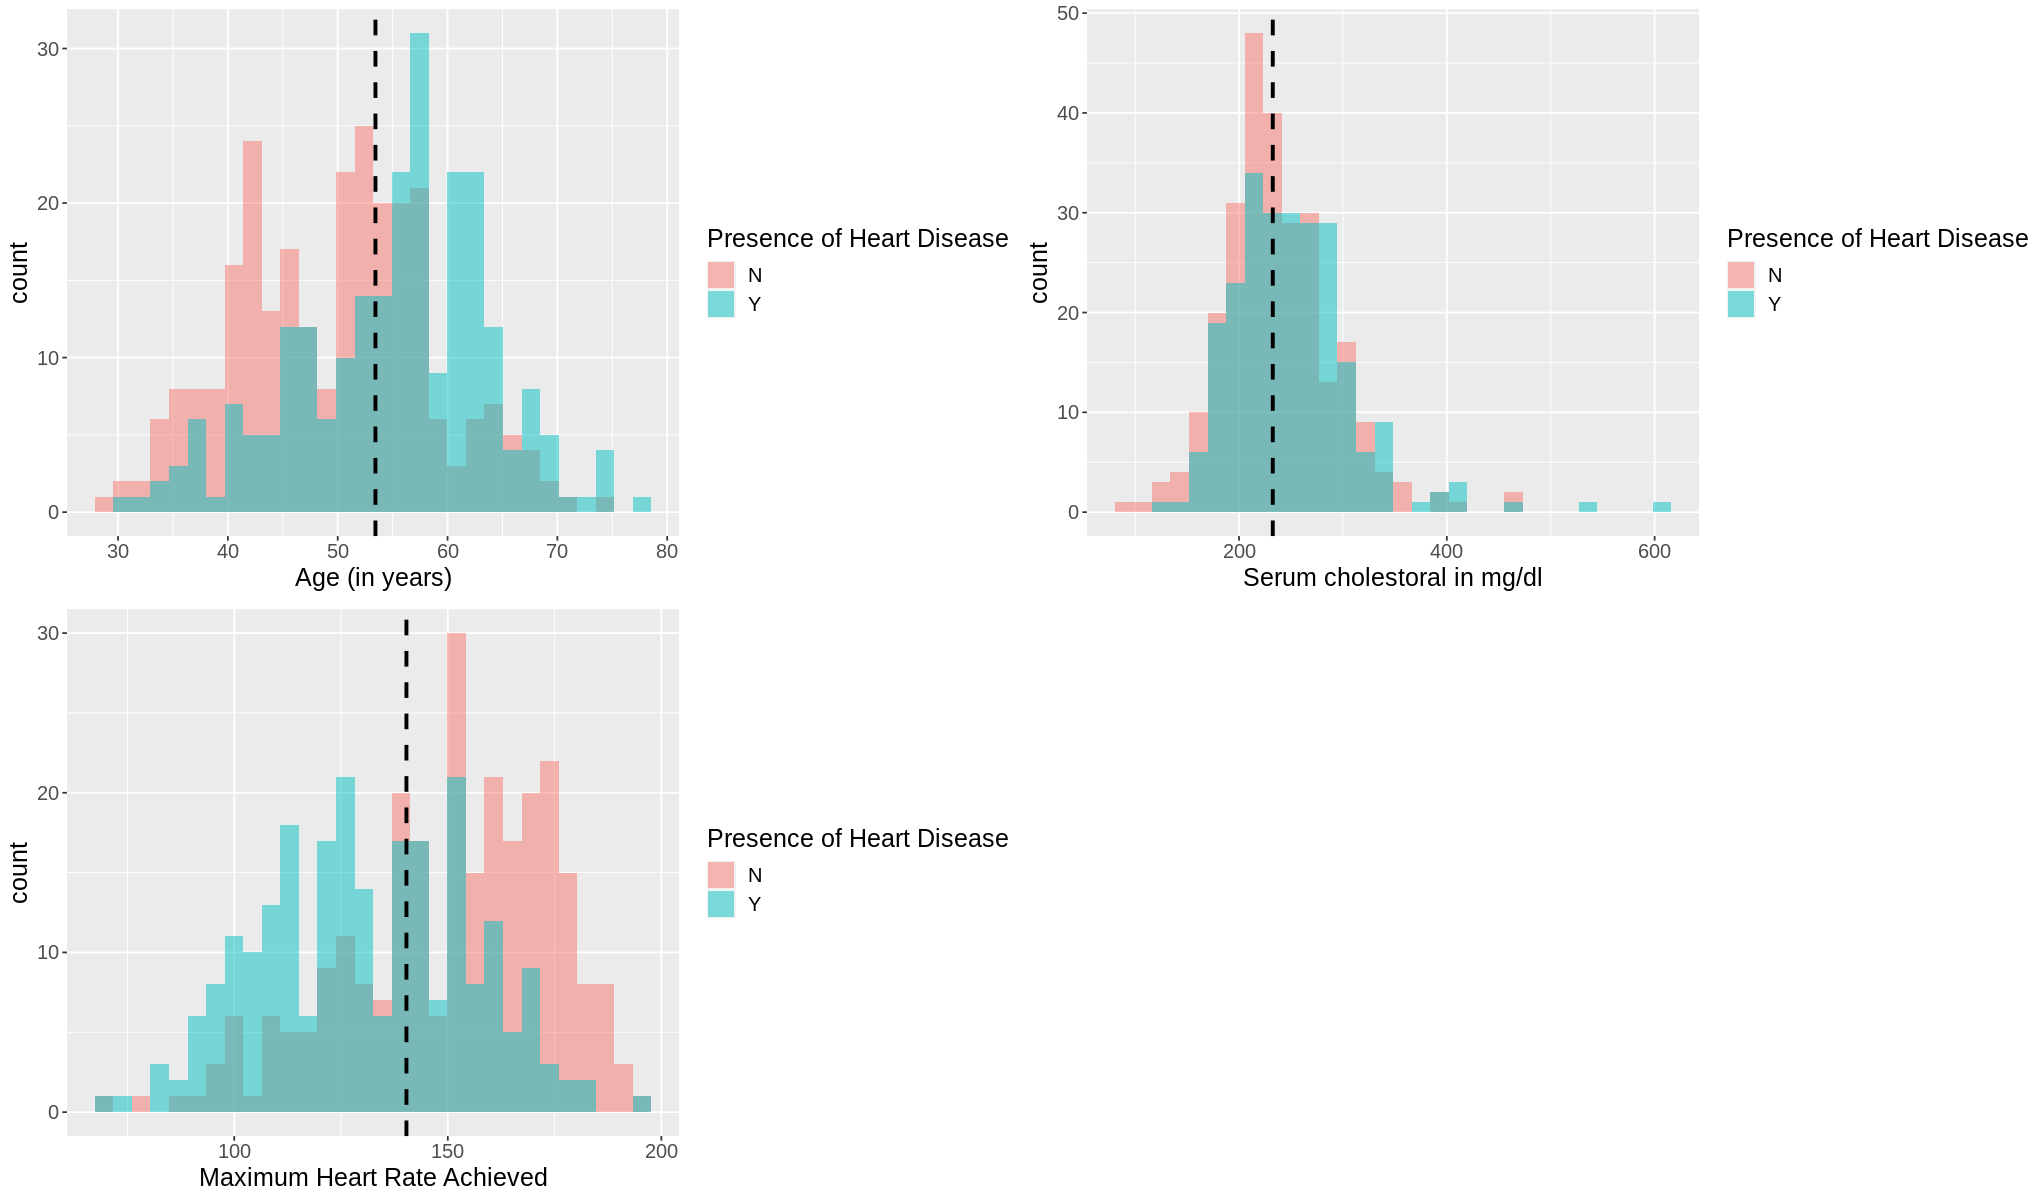

In [81]:
#visualising the data 

#changing the plot size 
options(repr.plot.height = 10, repr.plot.width=17)

# part 1: geom-points

age_chol <- heart_data_training %>% 
filter (chol != 0) %>%
ggplot(aes(x = age, y = chol, color = heart_disease)) + 
geom_point(stat = "identity", alpha = 0.5)+ 
labs(x="Age (in years)", y = "Serum cholestoral in mg/dl")+
theme (text = element_text (size = 15))

thalach_age <- heart_data_training %>% 
ggplot(aes(x = thalach, y = age, color = heart_disease)) + 
geom_point(stat = "identity", alpha = 0.5)+
labs(x = "Maximum Heart Rate Achieved", y= "Age (in years)")+
theme (text = element_text (size = 15))

chol_thalach <- heart_data_training %>% 
filter (chol != 0) %>%
ggplot(aes(x = chol, y = thalach , color = heart_disease)) + 
geom_point(stat = "identity", alpha = 0.5)+
labs(x = "Serum cholestoral in mg/dl" , y= "Maximum Heart Rate Achieved")+
theme (text = element_text (size = 15))

grid.arrange(age_chol, trestbps_age, thalach_trestbps, nrow=2)

# part 2: histograms
age_plot <- heart_data_training %>% 
ggplot(aes(x = age, fill = as_factor(heart_disease))) + 
geom_histogram(alpha=0.5, position = "identity") + 
geom_vline(xintercept = 53.4350, linetype="dashed", size = 1.1)+
labs(x="Age (in years)", fill = "Presence of Heart Disease")+
theme (text = element_text (size = 15))

chol_plot <- heart_data_training %>% 
    filter (chol != 0) %>%
ggplot(aes(x = chol, fill = as_factor(heart_disease))) + 
geom_histogram(alpha=0.5, position = "identity") + 
geom_vline(xintercept = 232.4731, linetype="dashed", size = 1.1)+
labs(x="Serum cholestoral in mg/dl", fill = "Presence of Heart Disease")+
theme (text = element_text (size = 15))

thalach_plot <- heart_data_training %>% 
ggplot(aes(x = thalach, fill = as_factor(heart_disease))) + 
geom_histogram(alpha=0.5, position = "identity") +
geom_vline(xintercept = 140.3143, linetype="dashed", size = 1.1)+
labs(x = "Maximum Heart Rate Achieved", fill = "Presence of Heart Disease")+
theme (text = element_text (size = 15))

grid.arrange(age_plot, chol_plot, thalach_plot, nrow=2)


# Side notes:
# the added dashed lines for histograms represents the mean value of each predictor
# the 0 cholestrols are filtered for the purpose of better visualization


After the visualization, we moved on to the actual classification part of the project. We started by omitting the NAs in our data to aid in classification. Afterwards, we created a recipe where we specified the predictor variables for the data along with standardizing the data as KNN classification relies on calculating the euclidean distance. Then, we created the spec where we specified the engine, the mode, and the formula that will be used to calculate the distance. 


In [77]:
#make a recipe
set.seed(1)


heart_recipe <- recipe (heart_disease ~  age + chol + thalach , heart_data_training) %>%
    step_scale (all_predictors()) %>%
    step_center (all_predictors()) 
heart_recipe

heart_spec <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) %>%
    set_engine ("kknn") %>%
    set_mode ("classification")
heart_spec


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Next, we created a tibble with various values of K and also created a vfold so that we can do cross validation. This was done to determine the best value of k which would give us the highest accuracy. Cross validation is done to make sure  our accuracy is not affected too much by data that ends in the training and the validation data set. Lastly, we combine it all into a workflow where the recipe and the spec is specified. We then collect the metrics(accuracy) and then plot it onto a plot which shows the accuracy associated with the respective value of K. 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6150275,5,0.02819784,Model01
2,accuracy,binary,0.6150275,5,0.02819784,Model02
3,accuracy,binary,0.6582466,5,0.01756342,Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
23,accuracy,binary,0.6934272,5,0.007384812,Model23
24,accuracy,binary,0.6934272,5,0.007384812,Model24
25,accuracy,binary,0.6894668,5,0.010494799,Model25


mean,neighbors
<dbl>,<int>
0.7013096,21


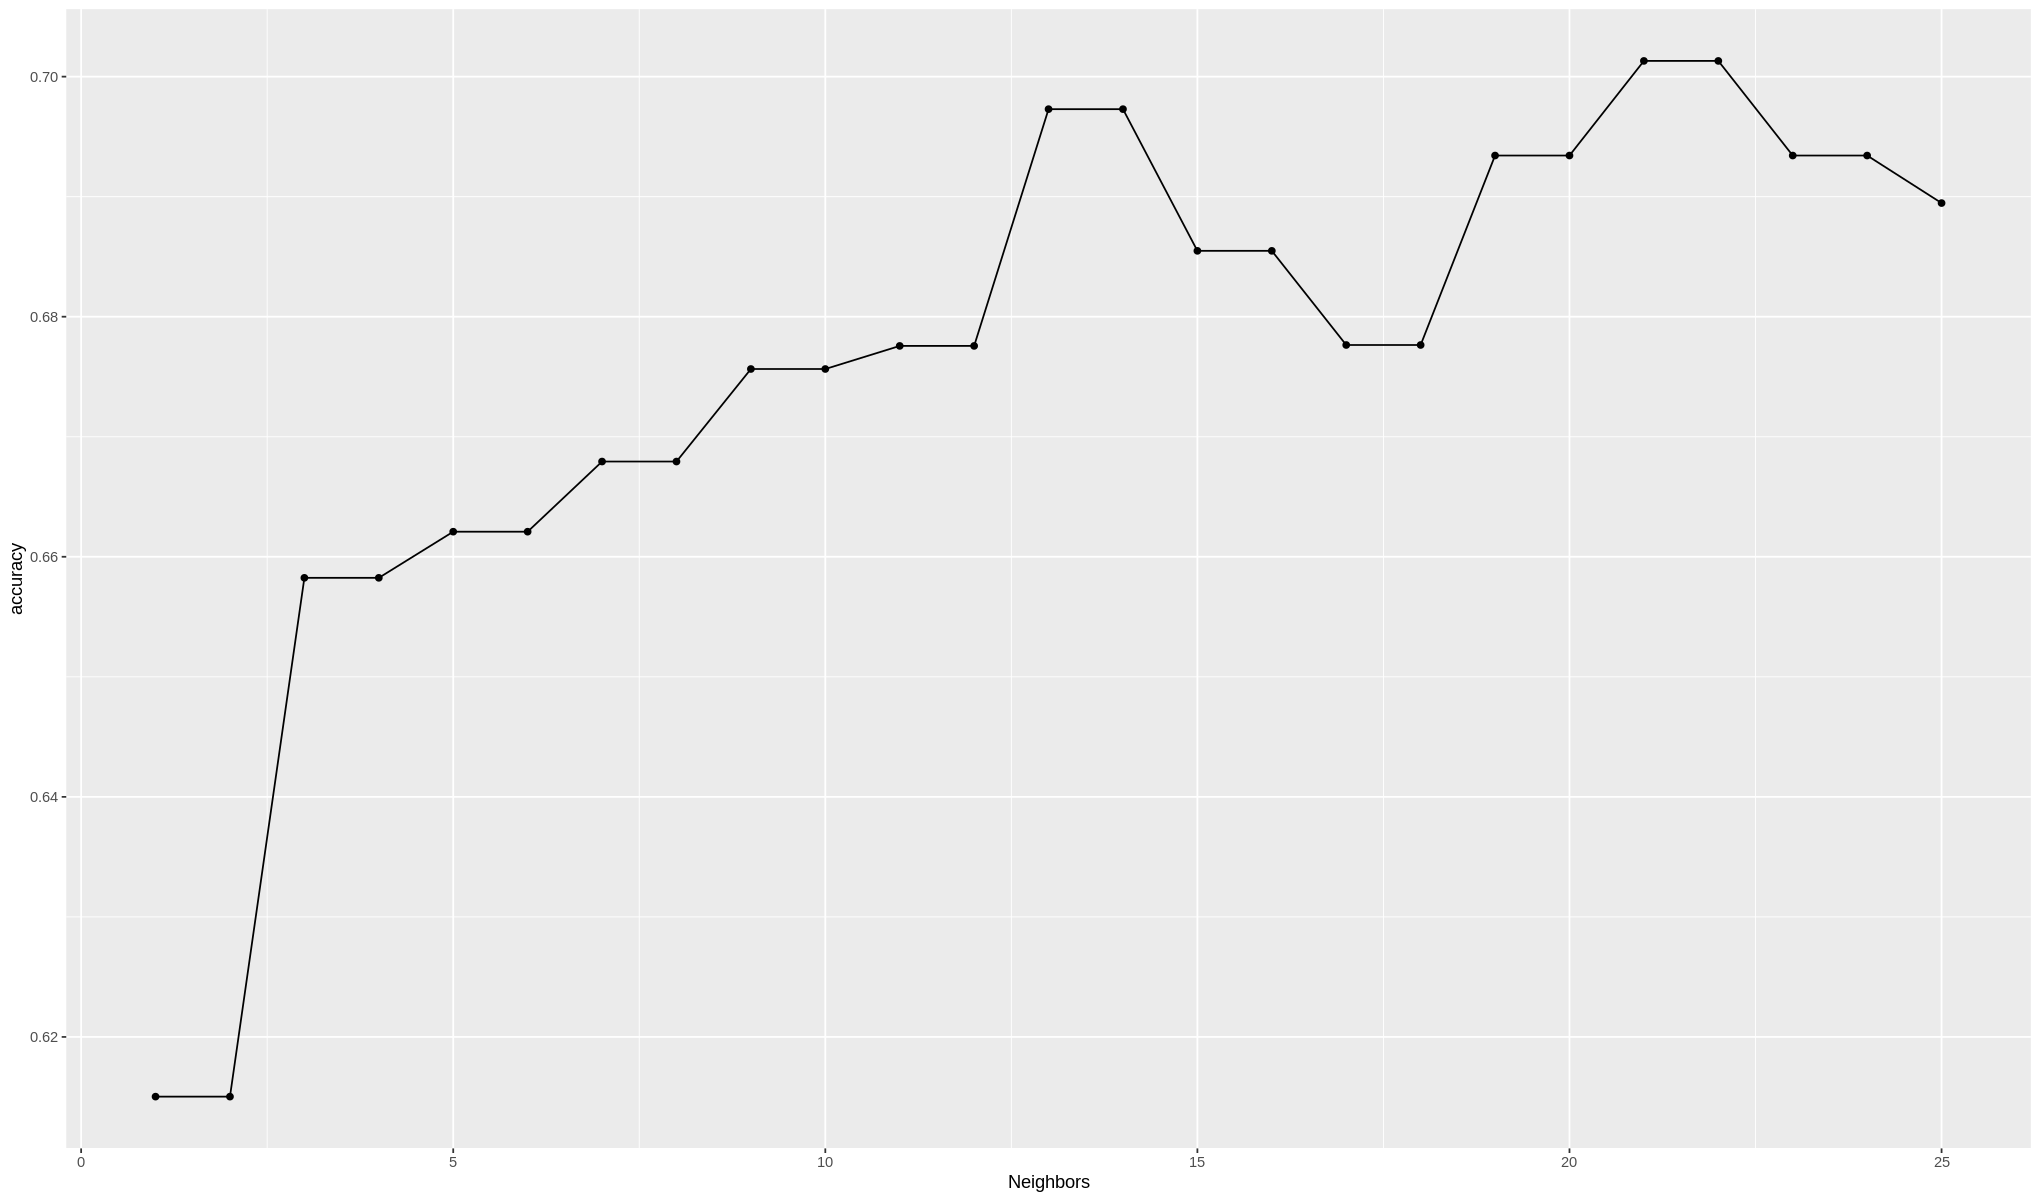

In [78]:
k_table <- tibble (neighbors = seq (1, 25))

heart_vfold <- vfold_cv (heart_data_training, v = 5, strata= heart_disease)

heart_workflow <- workflow()%>%
    add_recipe (heart_recipe) %>%
    add_model (heart_spec) %>%
    tune_grid (resamples = heart_vfold, grid = k_table) %>%
    collect_metrics () %>%
    filter (.metric == "accuracy")   
heart_workflow

heart_max_k <- heart_workflow %>%
    select (mean, neighbors) %>%
    arrange (desc (mean)) %>%
    slice (1) 
heart_max_k

heart_vs_k_plot <- ggplot (heart_workflow, aes (x = neighbors, y = mean)) + 
        geom_point () +
        geom_line () +
        labs (x = "Neighbors", y = "accuracy")
heart_vs_k_plot


In [79]:
set.seed(1)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 21) %>%
    set_engine("kknn")%>%
    set_mode("classification")

knn_fit <- workflow()%>%
    add_recipe(heart_recipe)%>%
    add_model(knn_spec) %>%
    fit(data = heart_data_training)

heart_test_predictions <- predict(knn_fit, heart_data_testing) %>%
  bind_cols(heart_data_testing)


heart_test_predictions_estimates <- heart_test_predictions %>%
  metrics(truth = heart_disease, estimate = .pred_class)%>%
  filter(.metric == "accuracy")
heart_test_predictions_estimates

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6706587


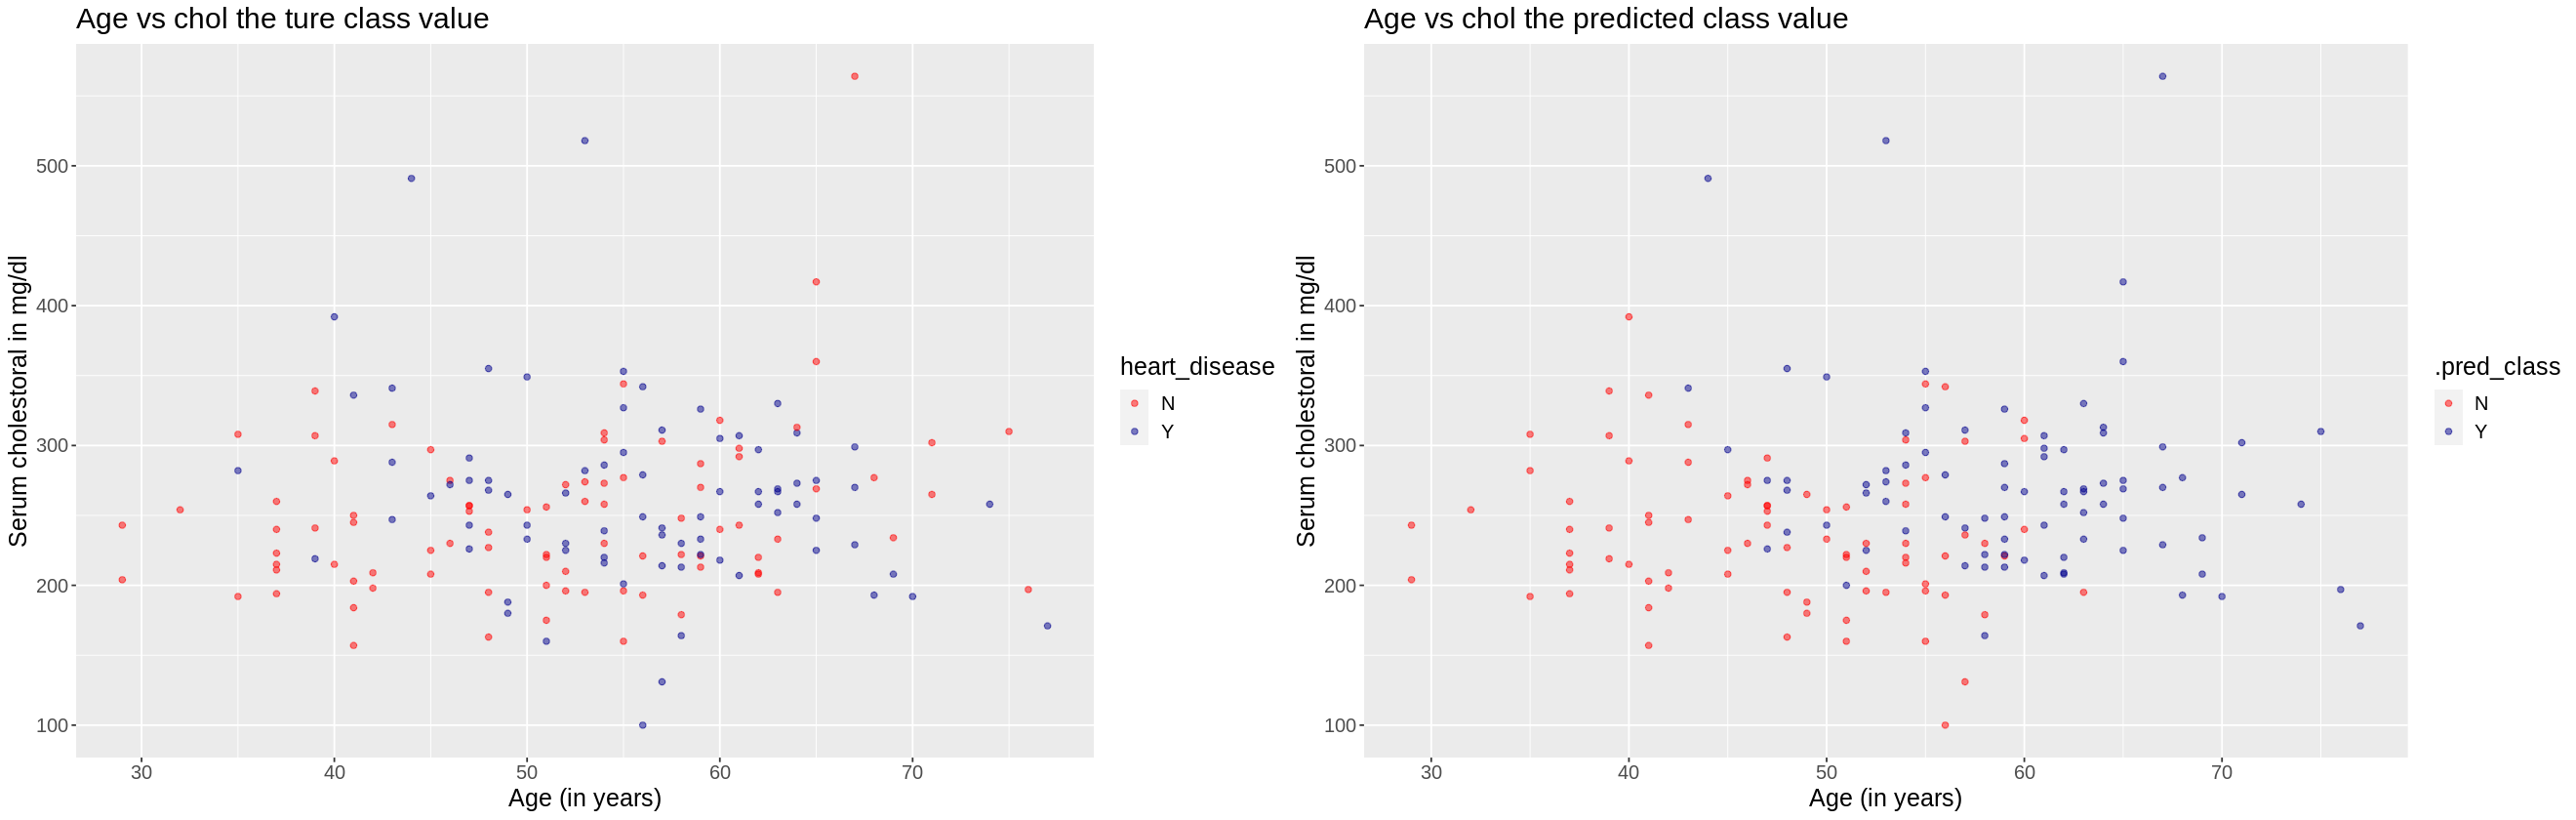

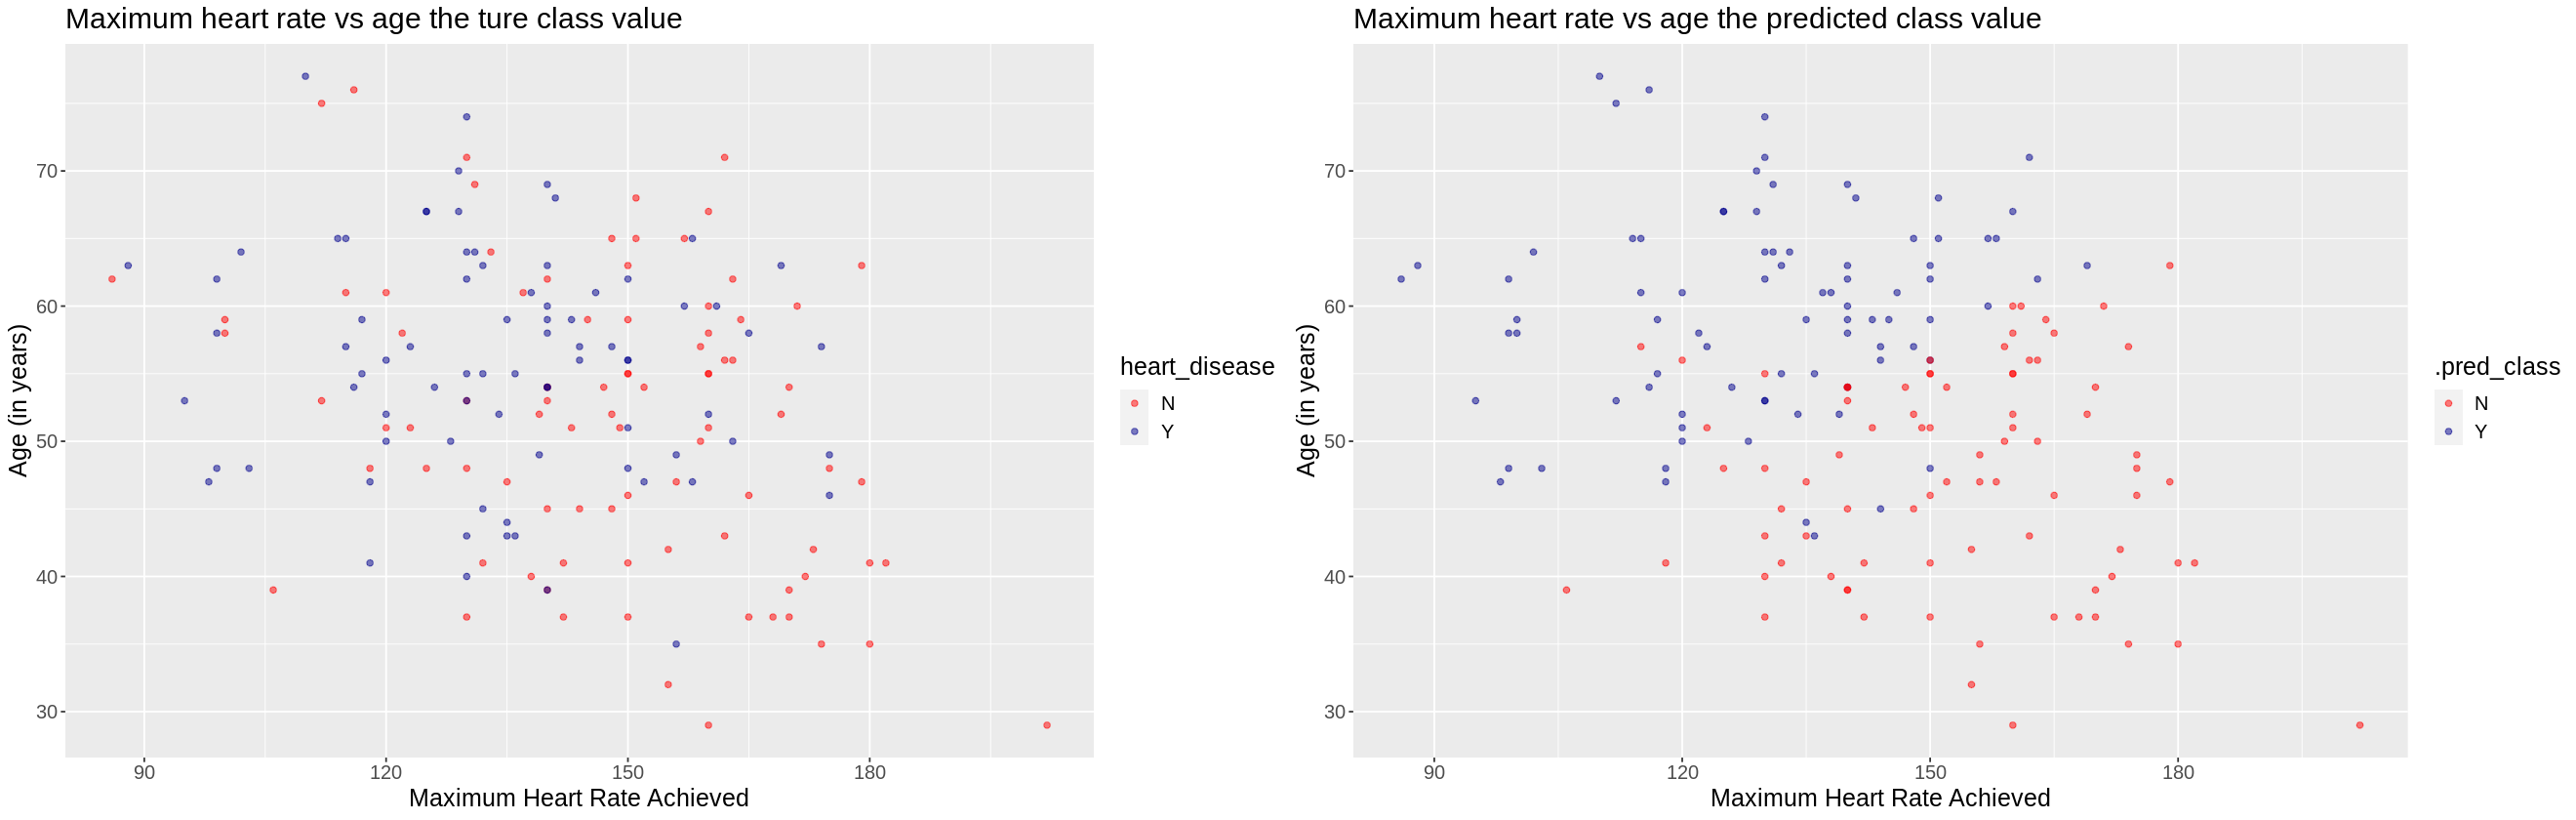

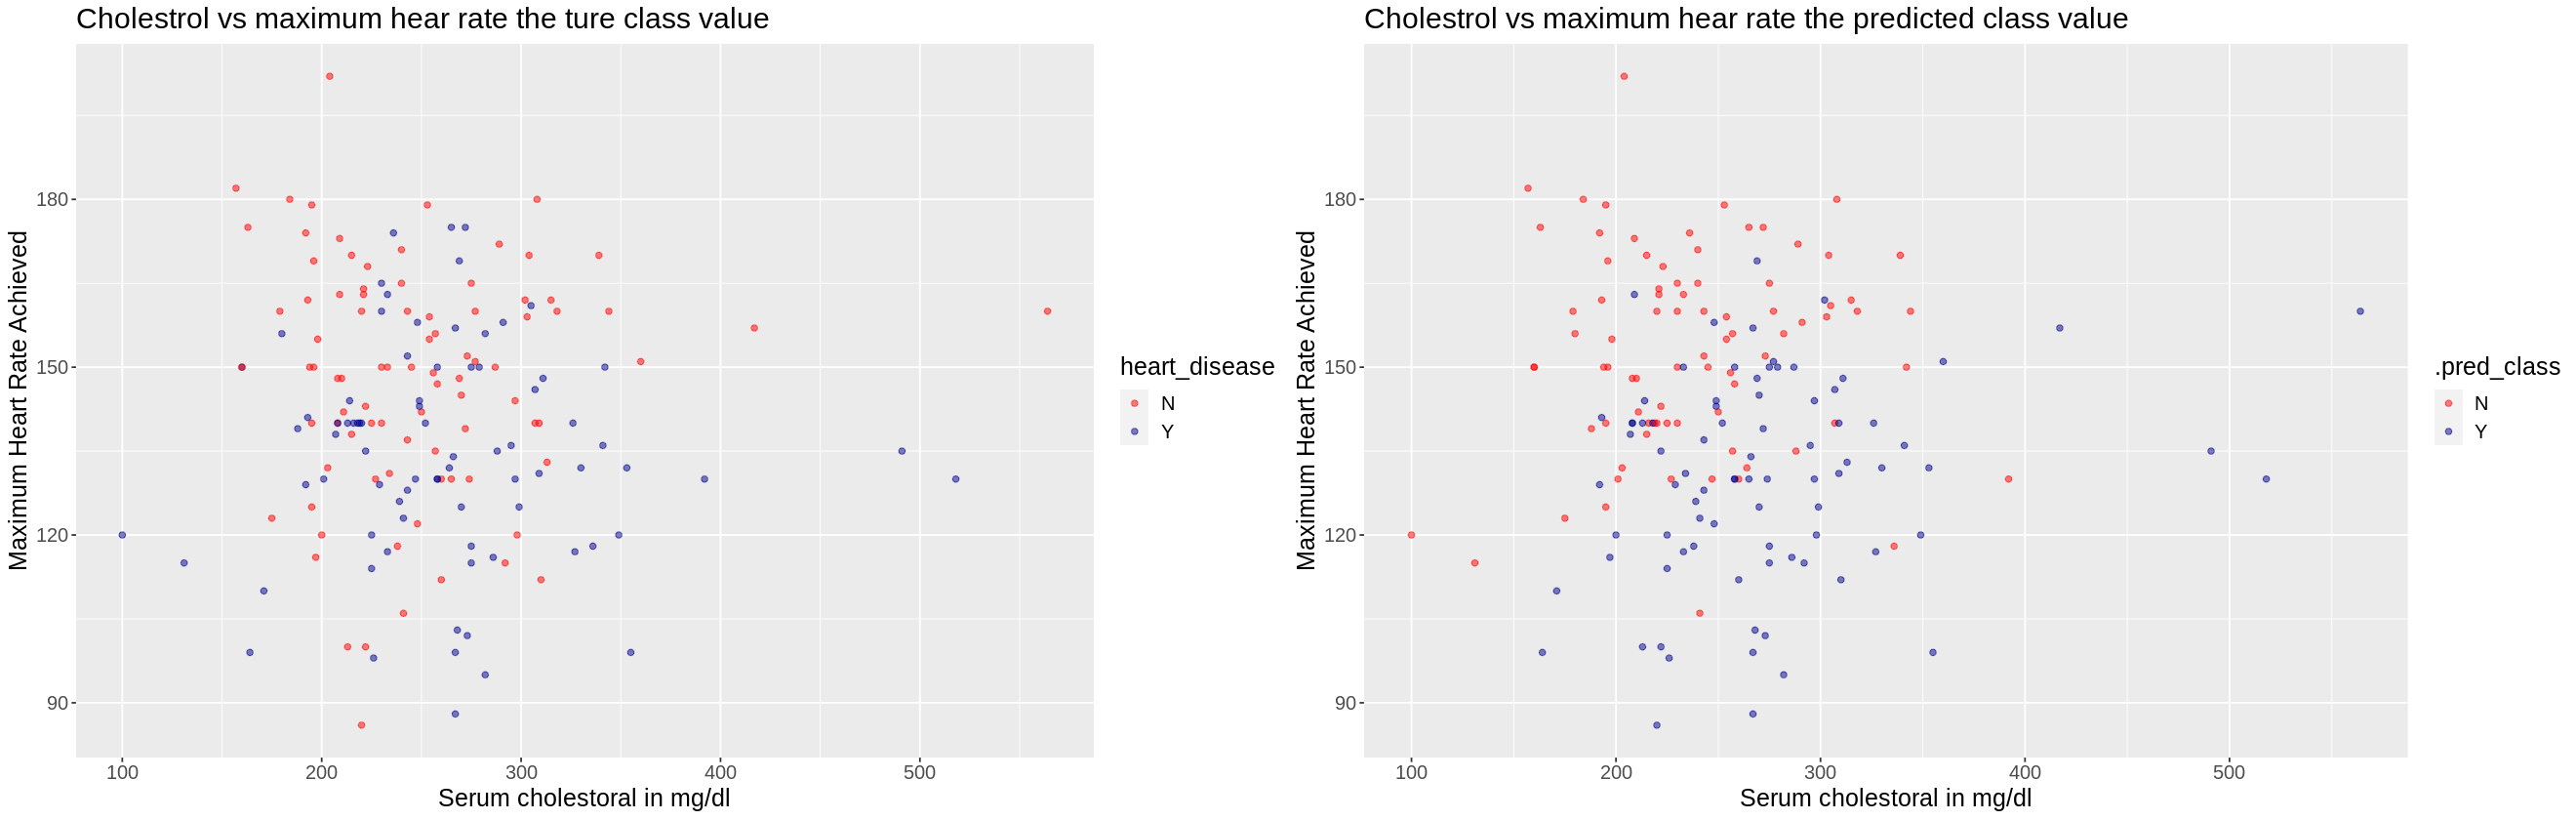

In [80]:
#Vissualization
#the actual plot vs the one that we predict
options(repr.plot.height = 7, repr.plot.width=22)


age_chol_true <- heart_data_testing %>% 
    ggplot(aes(x = age, y = chol, color = heart_disease)) + 
    geom_point(stat = "identity", alpha = 0.5)+ 
    labs(x="Age (in years)", y = "Serum cholestoral in mg/dl")+
    theme (text = element_text (size = 15)) +
    scale_color_manual(values = c("Y" = "DarkBlue", "N" = "Red")) +
    ggtitle ("Age vs chol the ture class value")


age_chol_pred <- heart_test_predictions %>% 
    ggplot(aes(x = age, y = chol, color = .pred_class)) + 
    geom_point(stat = "identity", alpha = 0.5)+ 
    labs(x="Age (in years)", y = "Serum cholestoral in mg/dl")+
    theme (text = element_text (size = 15)) +
    scale_color_manual(values = c("Y" = "DarkBlue", "N" = "Red")) +
    ggtitle ("Age vs chol the predicted class value")


grid.arrange(age_chol_true, age_chol_pred, nrow=1)

thalach_age_true <- heart_test_predictions %>% 
    ggplot(aes(x = thalach, y = age, color = heart_disease)) + 
    geom_point(stat = "identity", alpha = 0.5)+
    labs(x = "Maximum Heart Rate Achieved", y= "Age (in years)")+
    theme (text = element_text (size = 15)) +
    scale_color_manual(values = c("Y" = "DarkBlue", "N" = "Red")) +
    ggtitle ("Maximum heart rate vs age the ture class value")

thalach_age_pred <- heart_test_predictions %>% 
    ggplot(aes(x = thalach, y = age, color = .pred_class)) + 
    geom_point(stat = "identity", alpha = 0.5)+
    labs(x = "Maximum Heart Rate Achieved", y= "Age (in years)")+
    theme (text = element_text (size = 15))+
    scale_color_manual(values = c("Y" = "DarkBlue", "N" = "Red")) +
    ggtitle ("Maximum heart rate vs age the predicted class value")

grid.arrange(thalach_age_true, thalach_age_pred, nrow=1)

chol_thalach_true<- heart_test_predictions %>% 
    ggplot(aes(x = chol, y = thalach , color = heart_disease)) + 
    geom_point(stat = "identity", alpha = 0.5)+
    labs(x = "Serum cholestoral in mg/dl" , y= "Maximum Heart Rate Achieved")+
    theme (text = element_text (size = 15))+
    scale_color_manual(values = c("Y" = "DarkBlue", "N" = "Red")) +
    ggtitle ("Cholestrol vs maximum hear rate the ture class value")

chol_thalach_pred <- heart_test_predictions %>% 
    ggplot(aes(x = chol, y = thalach , color = .pred_class)) + 
    geom_point(stat = "identity", alpha = 0.5)+
    labs(x = "Serum cholestoral in mg/dl" , y= "Maximum Heart Rate Achieved")+
    theme (text = element_text (size = 15)) +
    scale_color_manual(values = c("Y" = "DarkBlue", "N" = "Red")) +
    ggtitle ("Cholestrol vs maximum hear rate the predicted class value")

grid.arrange(chol_thalach_true, chol_thalach_pred, nrow=1)

## Methods

The variables we plan on using in our model are: 
1. Age - [People age 65 and older are much more likely than younger people to suffer a heart attack, to have a stroke, or to develop heart disease and heart failure. ](https://www.nia.nih.gov/health/heart-health-and-aging). This can be due to the heart not being able to beat fast enough during physical activity or times of stress as it did earlier or due to the buildup of fatty deposits in the walls of arteries over the years. It is also evident from our plot that ss age increases, more proportion of people have heart disease; after the dashed line, representing the mean value, the ratio of people with heart disease is higher.
2. Cholesterol: [Increased amounts of cholesterol can build up in the wall of your arteries leading to the thinning of the arteries and ultimately leading to less blood flow to the heart muscle. This can lead to various heart diseases and even heart attacks, in some cases](https://www.webmd.com/heart-disease/guide/heart-disease-lower-cholesterol-risk) Similarly, we can see in our scatter and histogram plots that people with cholesterol of over 200 mg/dl are more likely to have heart disease.
3. Maximum Heart Rate Achieved: [A higher heart rate is a good thing that leads to greater fitness](https://www.hopkinsmedicine.org/health/wellness-and-prevention/understanding-your-target-heart-rate) A higher heart rate means that the heart is functioning well and is able to pump blood quickly and effectively. Lower maximum heart rate means that either the heart is unable to pump blood at higher speeds or that the person isn't doing activities that allow their heart rate to reach such levels, in most cases. Our plots also show that people who did not get to a certain maximum heart rate, around 140, had a significantly higher chance of heart failure. Furthermore, we are going to use the K-nearest neighbours classification algorithm to classify the new data points. We will first use our training data set to create a recipe and tuning and train the classifier using the cross-validation method. We then make predictions and evaluate our prediction's accuracy using the testing data set and visualize the result in the last step. To visualize the result of our analysis, we propose dividing the predictor variables into certain fixed intervals and figuring out what percentage of the people within that interval actually have heart diseases. This will allow us to create a bar chart with the percentage of people with heart disease on the y-axis and the intervals on the x-axis. In conjunction with this, we can also add an additional bar on each interval depicting the percentage of people with heart disease according to our classification model. This will allow us to see the relationship of the predictors with the target variable on the testing set and also allow us to judge the accuracy of our model.


## Expected Outcomes and Significance 

1-We are expecting to find that people with age higher than 50, Serum cholesterol greater than 200 mg/dl and maximum heart rate achieved less than 140  have heart disease.

2-According to this model, we will be able to predict whether people have heart disease early. So we can give them treatment early and therefore reduce the severity and mortality of heart disease. This will also give us an insight into what causes heart disease and allow for the prevention of heart diseases. 

3-Instead of predicting whether someone has heart disease or not, we can move over to predict the possibility of the person having heart disease. This will be much better at reducing mortality as even if the person does not have heart disease, we can see if they are at high risk for the disease and treat accordingly.